<a href="https://colab.research.google.com/github/VamBay/testRepoForDS4BME2020/blob/master/lab1_Yuanwei_Xu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names (Enter your names below)
Student 1 Name : ***Yuanwei Xu***    JHED : **yxu105**

Student 2 Name and JHED (If applicable):  ...

# Heart rate estimation, signal de-noising and mobile health
The goal of this lab is to study an algorithm for correctly retrieving the timing instants of an ECG (EKG) time series. We will implement a simplified variant of the [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings. Towards the end of the lab you will be asked to apply your algorithms to the problem of heart rate estimation using a mobile device.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

***

### Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Signal Generation -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $10$ equally spaced pulses over a time span of $10\ s$.  Each pulse should have a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Plot the generated signal over time adding the appropriate labels for the axis.


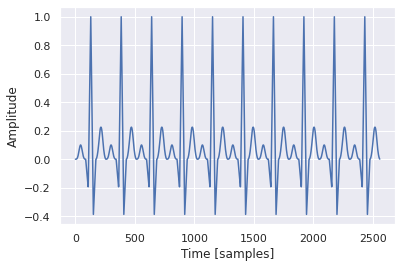

In [11]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a single synthetic ECG template of unit length (support).
    For example, for a sampling frequency of f_s, use x = np.linspace(0,1, f_s, endpoint=False)
    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)


# ============================================================================
# Start your code below this line
# ============================================================================
# ...

f_s = 256
t = np.linspace(0,1, f_s, endpoint=False)
y =ecg_wave(t)

# Generate unit impulses an
imp = signal.unit_impulse(2560, [128,384,640,896,1152,1408,1664,1920,2176,2432])
an = np.absolute(imp)

# Generate 10 ECG pulses
ecg_train = np.convolve(y,an,mode='same')

import matplotlib.pyplot as plt
plt.plot(np.arange(0, 2560), ecg_train)
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

* **Simulate Noise -** Generate a noisy version of the synthetic ECG signal generated by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations.

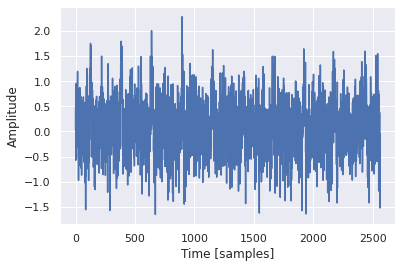

In [ ]:
# ============================================================================
# Write your code here
# ============================================================================
# ...
gauss_noise = 0.5*np.random.randn(2560)
noisy_ecg = ecg_train + gauss_noise
plt.plot(np.arange(0, 2560), noisy_ecg)
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

* **Find Peaks -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. First you should implement template matching by correlating the noisy signal with a template ECG pulse using `np.correlate`.   We recommend that you normalize the signal to range $[0,1]$ using `noralize_range` before thresholding. Then plot the result. Next choose a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function with the `height` parameter set to the your chosen threshold.  Print the times of each peak in seconds.

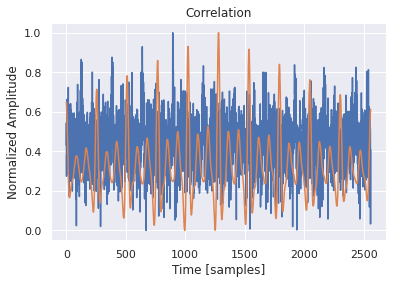

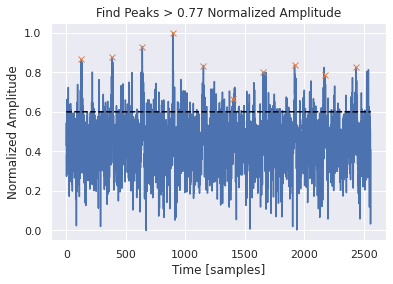

[ 126  384  639  895 1153 1404 1655 1919 2177 2434]


In [52]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:    
        return x
    
# ============================================================================
# Start your code below this line
# ============================================================================
# ...
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

norm_ecg = normalize_range(noisy_ecg)
plt.plot(np.arange(0, 2560), norm_ecg)

corr_ecg = normalize_range(np.correlate(noisy_ecg, ecg_train, mode="same"))
plt.plot(corr_ecg)
plt.title('Correlation')
plt.xlabel('Time [samples]')
plt.ylabel('Normalized Amplitude')
plt.grid(True)
plt.show()

peaks, _ = find_peaks(norm_ecg, height=(0.6, 1),distance = 250)
np.diff(peaks)
xline06=[0.6 for i in range(2560)]
plt.plot(norm_ecg)
plt.plot(peaks, norm_ecg[peaks], "x")
plt.plot(xline06,"--",color="black")
plt.title('Find Peaks > 0.77 Normalized Amplitude')
plt.xlabel('Time [samples]')
plt.ylabel('Normalized Amplitude')
plt.grid(True)
plt.show()
print (peaks)

In [53]:
peaks_time_series = peaks/256
print (peaks_time_series)

[0.4921875  1.5        2.49609375 3.49609375 4.50390625 5.484375
 6.46484375 7.49609375 8.50390625 9.5078125 ]


* **RR Intervals -** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number intervals between peaks. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


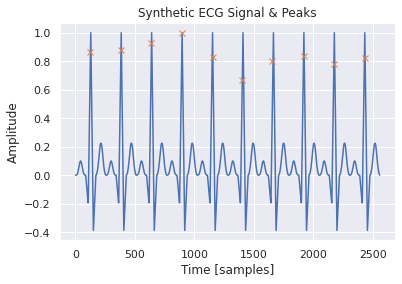

In [54]:
# ============================================================================
# Write your code here
# ============================================================================
# ...
plt.plot(ecg_train)
plt.plot(peaks, norm_ecg[peaks],'x')
plt.title('Synthetic ECG Signal & Peaks')
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [55]:
# Calculated BPM based on peaks predicted 
bpm =[]
for i in range(1,len(peaks)):
  bpm.append(256*60/(peaks[i]-peaks[i-1])) 
print(bpm)

# Resting BPM should be smaller than 100 BPM
rest_bpm = [s for s in bpm if s < 100]
print(rest_bpm)

#Average BPM
average_bpm = sum(rest_bpm)/len(rest_bpm)
print("The estimate of the average heart beat rate [BPM] is ", average_bpm)

[59.53488372093023, 60.23529411764706, 60.0, 59.53488372093023, 61.19521912350598, 61.19521912350598, 58.18181818181818, 59.53488372093023, 59.766536964980546]
[59.53488372093023, 60.23529411764706, 60.0, 59.53488372093023, 61.19521912350598, 61.19521912350598, 58.18181818181818, 59.53488372093023, 59.766536964980546]
The estimate of the average heart beat rate [BPM] is  59.90874874158315


### QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal where we don't know a priori the shape of the QRS-complex waeform. There are different
sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal
noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy 
individual where signal distortion comes solely from the acquisition process. The procedure that we
will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins
algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

* **Effect of noise** - Load the signal **ecg_mitnst.json**  You may have to change `path` to point to the correct loation where you downloaded **ecg_mitnst.json**. The loaded `data` dictionary will contain four fields.  `fs` is the sampling frequency, `voltage` is the measured voltage in *mV* at corresponding `time` points and `t_k` contains the indices of the peaks.  Plot the voltage over time with the given peaks. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

**Code for Problem (a) - Load File and Plot**

In [12]:
import pandas as pd
# ============================================================================
# Edit path variable below if necessary
# ============================================================================

try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = 'gdrive/My Drive/DS4BME/lab1-VamBay-master/ecg_mitnst.json' # Change path to location of data
except:
    # Executes if running locally (e.g. Anaconda)
    path = 'ecg_mitnst.json' # Change path to location of data

with open(path,'r') as infile: data = json.load(infile)

# print data to see dictionary fields
print(data.keys())

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).
dict_keys(['fs', 'time', 'tk', 'voltage'])


Text(0, 0.5, 'Voltage/mV')

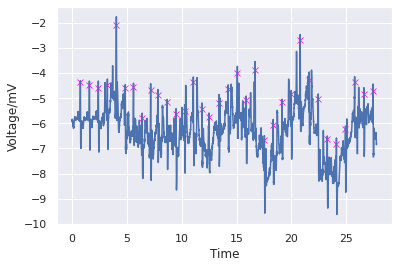

In [176]:
import json 
  
# Opening JSON file 
f = open('gdrive/My Drive/DS4BME/lab1-VamBay-master/ecg_mitnst.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  
# Iterating through the json 
# list 
time = []
tk = []
vol = []
fs = data["fs"]

for i in data['time']: 
    time.append(i) 

for j in data['tk']:
    tk.append(j) 

for k in data['voltage']:
    vol.append(k) 

# Closing file 
f.close() 

# Marking Peaks According to tk indices
time_sub=[]
vol_sub=[]
for i in tk:
  time_sub.append(time[i])
  vol_sub.append(vol[i])

# Plotting
sns.lineplot(x=time, y=vol)
sns.scatterplot(x=time_sub, y=vol_sub, marker="x", color="magenta")
plt.xlabel('Time')
plt.ylabel('Voltage/mV')

* **Pan-Tompkins Algorithm -** In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

  1. _Bandpass filtering:_ Follow the steps described in the instructions in order to perform a bandpass filtering operation as the concatenation of lowpass and highpass filtering operations.  For your convinence we have provided `boxFilter` and `triangleFilter` functions.
  
  2. _Differentiation:_ Use the discrete filter $d_n$ to approximate the derivative of the underlying signal:
  
    $$ d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big) $$
  
    The filter is intended to localize the steepest region in the QRS-complex.
  
  3. _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform.
  
  3. _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal.
  
  4. _Peak detection:_ Use a peak detector to estimate the locations of the peaks add them to the previous plot. Estimate the sequence of **RR** intervals and plot the corresponding heart beat rate over time.
 

**Code for Problem (b) - Bandpass Filtering**






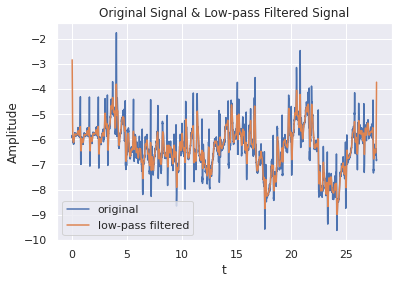

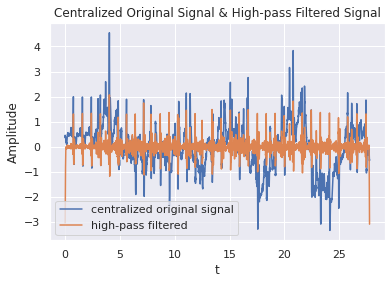

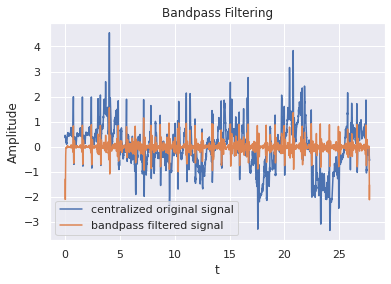

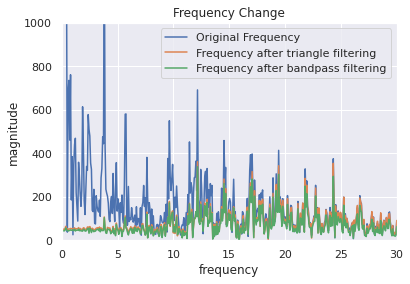

In [98]:
def boxFilter(L):
    """
    Genearte box filter of length L
    """
    h = np.ones(L)
    return h/np.sum(h)

def triangleFilter(L):
    """
    Generate triangle filter of length L
    """
    h = np.convolve(boxFilter(L//2), boxFilter(L//2))
    h = np.concatenate(([0],h))
    if L % 2: h = np.concatenate((h,[0]))
    return h/np.sum(h)


# ============================================================================
# Write your code here
# ============================================================================
# ...

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
fs =360
t = np.arange(10000) / fs

#### Highpass Filtering ####

triangle_filter = triangleFilter(50)
vol_triangle = np.convolve(triangle_filter, vol, mode='same')
vol_after_triangle = vol-vol_triangle

## Original signal and low-passed signal

plt.plot(t, vol, label ='original')
plt.plot(t, vol_triangle, label ='low-pass filtered')
plt.legend(loc='lower left')
plt.title('Original Signal & Low-pass Filtered Signal')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.show()

## Put the original signal at roughly the same line as the filtered signal for better comparison
vol_center = vol - np.mean(vol)
plt.plot(t,vol_center, label='centralized original signal')
plt.plot(t, vol_after_triangle, label='high-pass filtered')
plt.legend(loc='lower left')
plt.title('Centralized Original Signal & High-pass Filtered Signal')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.show()

#### Lowpass Filtering ####

box_filter = boxFilter(10)
vol_bandpass = np.convolve(box_filter, vol_after_triangle, mode="same")
plt.plot(t, vol_center, label='centralized original signal')
plt.plot(t, vol_bandpass, label='bandpass filtered signal')
plt.legend(loc='lower left')
plt.title('Bandpass Filtering')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.show()

### Check frequency change among original, after triangle filtering and after box filtering (bandpass filtering)

freq_original = np.absolute(np.fft.fftshift(np.fft.fft(vol)))
freq_after_triangle= np.absolute(np.fft.fftshift(np.fft.fft(vol_after_triangle)))
freq_after_bandpass= np.absolute(np.fft.fftshift(np.fft.fft(vol_bandpass)))

plt.plot(fs/np.pi*np.arange(-np.pi,np.pi,2*np.pi/(len(freq_original))), freq_original, label='Original Frequency')
plt.plot(fs/np.pi*np.arange(-np.pi,np.pi,2*np.pi/(len(freq_after_triangle))), freq_after_triangle, label ='Frequency after triangle filtering')
plt.plot(fs/np.pi*np.arange(-np.pi,np.pi,2*np.pi/(len(freq_after_bandpass))), freq_after_bandpass, label ='Frequency after bandpass filtering')
plt.legend(loc='upper right')
plt.title('Frequency Change')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.xlim(0,30)
plt.ylim(0,1000)
plt.show()


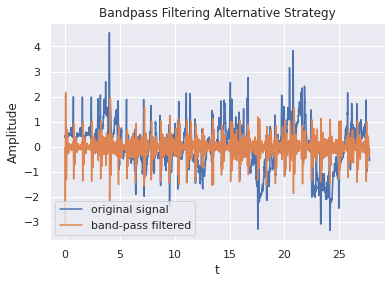

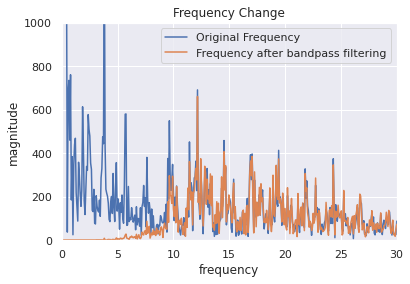

In [99]:
### Alternative Strategy for Bandpass Filtering ###
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

vol_bandpass_2 = butter_bandpass_filter(vol, 5, 50, 360, order =5)
plt.plot(t, vol_center, label='original signal')
plt.plot(t,vol_bandpass_2, label='band-pass filtered')
plt.legend(loc='lower left')
plt.title('Bandpass Filtering Alternative Strategy')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.show()

### Check frequency change ###

freq_after_bandpass_2= np.absolute(np.fft.fftshift(np.fft.fft(vol_bandpass_2)))

plt.plot(fs/np.pi*np.arange(-np.pi,np.pi,2*np.pi/(len(freq_original))), freq_original, label='Original Frequency')
plt.plot(fs/np.pi*np.arange(-np.pi,np.pi,2*np.pi/(len(freq_after_bandpass_2))), freq_after_bandpass_2, label ='Frequency after bandpass filtering')
plt.legend(loc='upper right')
plt.title('Frequency Change')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.xlim(0,30)
plt.ylim(0,1000)
plt.show()


**Code for Problem (c) - Differentiation**

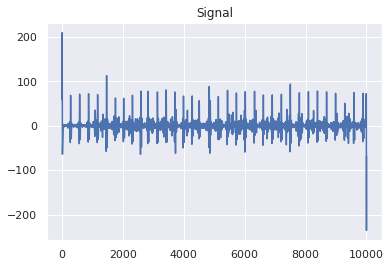

In [100]:
## Transfer function from paper "A Real-Time QRS Detection Algorithm."
# H(z)=(1/8T)(-z^-2-2z^-1+2z^1+z^2)
T = 1/fs
delta = np.array([-1, -2, 0, 2, 1]) * (1 / 8 / T)
# Differentiation
vol_deriv = np.convolve(vol_bandpass, delta)
plt.title('Signal')
plt.plot(vol_deriv)
plt.show()

**Code for Problem (d) - Squaring**

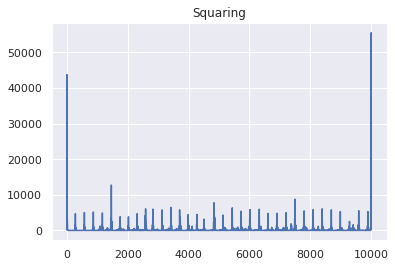

In [101]:
vol_sqr = vol_deriv**2
plt.plot(vol_sqr)
plt.title('Squaring')
plt.show()

**Code for Problem (e) - Box Filtering**

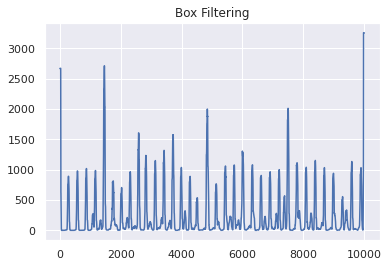

In [102]:
box_50 = boxFilter(50)
int_vol = np.convolve (box_50, vol_sqr, mode='same')
plt.plot(int_vol)
plt.title('Box Filtering')
plt.show()

**Code for Problem (f) - Finding Peaks and BPM**

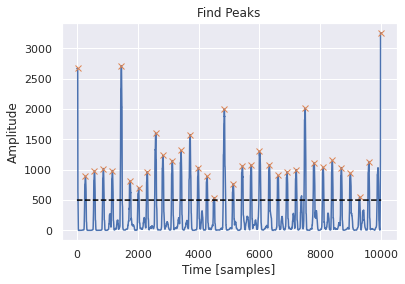

[  25  280  574  870 1167 1461 1752 2027 2309 2586 2823 3136 3421 3718
 3989 4279 4517 4845 5136 5440 5731 5997 6327 6616 6908 7208 7498 7793
 8095 8392 8691 8990 9291 9591 9979]


In [173]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

peaks_vol, _ = find_peaks(int_vol, height=(500, 4000),distance=200)
xline=[500 for i in range(10000)]
plt.plot(int_vol)
plt.plot(peaks_vol, int_vol[peaks_vol], "x")
plt.plot(xline,"--",color="black")
plt.title('Find Peaks')
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
peaks_indices = peaks_vol
print (peaks_indices)

In [174]:
peaks_time_series_vol=peaks_vol/360
print(peaks_time_series_vol)

[ 0.06944444  0.77777778  1.59444444  2.41666667  3.24166667  4.05833333
  4.86666667  5.63055556  6.41388889  7.18333333  7.84166667  8.71111111
  9.50277778 10.32777778 11.08055556 11.88611111 12.54722222 13.45833333
 14.26666667 15.11111111 15.91944444 16.65833333 17.575      18.37777778
 19.18888889 20.02222222 20.82777778 21.64722222 22.48611111 23.31111111
 24.14166667 24.97222222 25.80833333 26.64166667 27.71944444]


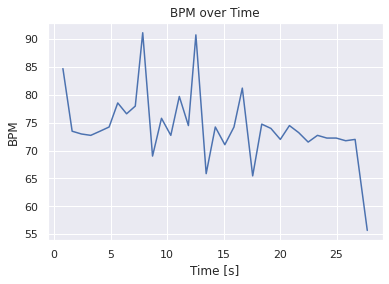

In [175]:
# Calculated BPM based on peaks predicted in MIT ECG file 
bpm_vol =[]
for i in range(len(peaks_indices)):
  bpm_vol.append(fs*60/(peaks_indices[i]-peaks_indices[i-1])) 

bpm_time_series = np.ndarray.tolist(peaks_time_series_vol)

del bpm_time_series[0]
del bpm_vol[0]
plt.plot(bpm_time_series, bpm_vol)
plt.title('BPM over Time')
plt.xlabel('Time [s]')
plt.ylabel('BPM')
plt.grid(True)
plt.show()
